<a href="https://www.kaggle.com/code/nishantsinghsiddhu/imdb-movie-review-96-accuracy?scriptVersionId=113557034" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis of IMDB Movie Reviews:

<b>Problem Statement</b>:

Predict if a review is postive or negative

## Import necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from collections import Counter
from bs4 import BeautifulSoup
from textblob import TextBlob
import string, time
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
!pip install contractions
import contractions
import plotly.express as px
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.5 MB/s eta 0:00:00


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/neg-words/neg.txt
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
/kaggle/input/pos-words/pos.txt


### Helper function which returns all the words in a document
* ##### *Readwords for .txt files (readwords)*</b>
return words from a text file

In [2]:
def readwords( filename ):
    """
    return words from a text file
    
    Arguments:
    filename -- any .txt format file
    
    Returns:
    list -- python list containing words  
    """

    f = open(filename)
    words = [ line.rstrip() for line in f.readlines()]
    return words

## Loading Datasets

In [3]:
%%time

positive = readwords('/kaggle/input/pos-words/pos.txt')
negative = readwords('/kaggle/input/neg-words/neg.txt')
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

CPU times: user 621 ms, sys: 205 ms, total: 826 ms
Wall time: 1.69 s


### Descriptive Statistics

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#### Since there are some duplicate data, we can drop duplicates

In [5]:
df.drop_duplicates(inplace=True)

## Data Cleaning
#### For this I have created several functions that perform specific task on the dataset.    
* ##### <b>*lowercase*</b>
helper function which lowercases a single document at a time
* ##### <b>*Remove Contraction (rem_contractions)*</b>
helper function to remove contraction using contractions library, eg. you're --> you are
* ##### <b>*Remove Punctuations (rem_punctn)*</b>
 helper function to remove Punctuations from  a document, eg. .>!...
* ##### <b>*Remove html tags (strip_html)*</b>
helper function to html tags from a document, using BeautifulSoup library
* ##### <b>*Remove URL's (remove_url)*</b>
helper function to remove URL's from a document, eg www.abc.com
* ##### <b>*Remove Emoji (remove_emoji)*</b>
helper function to remove emojis from a document
* ##### <b>*Remove Stopwords (remove_stopwords)*</b>
helper function to stop words from a document
* <b>*Calculating Positive negative words in a sentence (pos_neg)*</b>

In [6]:
%%time

tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')
exclude= string.punctuation
#Removes Punctuations

def lowercase(text):
    """
    helper function which lowercases a single document 
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    text.lower -- python string of document with lowercase text
    """
    return text.lower()

def rem_contractions(text):
    """
    helper function to remove contraction using contractions library
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    Sting -- python string with fixed contractions
    """
    return contractions.fix(text)

def rem_punctn(text):
    """
    helper function to remove Punctuations from  a document
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    String -- python string with removed Punctuations
    """
    return text.translate(str.maketrans('','', exclude))

#Removes HTML syntaxes
def strip_html(text):
    """
    helper function to html tags from a document, using BeautifulSoup library
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    String -- python string with removed html tags
    """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removes URL data
def remove_url(text):
    """
    helper function to remove URL's from a document
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    String -- python string document with removed URL's
    """
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',text)
    return data


# def spell_check(data):
#     """
#     helper function to check spellings of a document, using TextBlob library
    
#     Arguments:
#     text -- takes one text review at a time
    
#     Returns:
#     String -- python string with corrected spellings
#     """
#     txtblb = TextBlob(data)
#     return txtblb.correct().string


#Removes Emojis
def remove_emoji(text):
    """
    helper function to remove emojis from a document
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    String -- python string with removed emojis from the emoji_clean
    """
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_clean.sub(r'',text)

def remove_stopwords(text):
    """
    helper function to stop words from a document
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    string -- python string with removed stopwords
    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]

    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def simple_stemmer(text):
    """
    helper function to update number of positive and negative words in a sentence
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    parameters -- python tuple containing (positive, negative) words count
    """
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text



def pos_neg(text):
    """
    helper function to update number of positive and negative words in a sentence
    
    Arguments:
    text -- takes one text review at a time
    
    Returns:
    Tuple -- python tuple containing (positive, negative) words count
    """

    paragraph = text

    count = Counter(paragraph.split())

    pos = 0
    neg = 0
    for key, val in count.items():
        key = key.rstrip('.,?!\n') # removing possible punctuation signs
        if key in positive:
            pos += val
        if key in negative:
            neg += val

    return (pos, neg)

CPU times: user 2.64 ms, sys: 4 µs, total: 2.64 ms
Wall time: 6.07 ms


### Calling functions above to clean data

In [7]:
%%time

df['review']= df['review'].apply(lambda z: lowercase(z))
df['review']= df['review'].apply(lambda z: rem_contractions(z))
df['review']= df['review'].apply(lambda z: rem_punctn(z))

df['review']= df['review'].apply(lambda z: strip_html(z))
df['review']= df['review'].apply(lambda z: remove_url(z))
df['review']= df['review'].apply(lambda z: remove_emoji(z))
df['review']= df['review'].apply(lambda z: remove_stopwords(z))

CPU times: user 53.2 s, sys: 72.9 ms, total: 53.3 s
Wall time: 53.3 s


### Creating additional features from Reviews
* #### Number of positive words
* #### Number of negative words
* #### Ratio of Positive to negative words

In [8]:
%%time

df['pos_neg_word_counts']=df['review'].apply(lambda z: pos_neg(z))
df[['positive_words', 'negative_words']] = pd.DataFrame(df['pos_neg_word_counts'].tolist(), index=df.index)
df['ratio_pos_neg'] = df['positive_words']/ (df['negative_words'] + 0.01) # implicitly adding one to the denominator to avoid divide by zero error
df.drop(['pos_neg_word_counts'], axis=1, inplace=True)
df.head()

CPU times: user 9min 27s, sys: 164 ms, total: 9min 27s
Wall time: 9min 28s


,review,sentiment,positive_words,negative_words,ratio_pos_neg
0,one reviewers mentioned watching 1 oz episode ...,positive,11,18,0.610772
1,wonderful little production br br filming tech...,positive,11,1,10.891089
2,thought wonderful way spend time hot summer we...,positive,11,6,1.830283
3,basically family little boy jake thinks zombie...,negative,2,6,0.332779
4,petter matteis love time money visually stunni...,positive,15,2,7.462687


### Transfrming the Corpus 
#### lemmatizer 

In [9]:
#Lemmatize the dataset
def lemma_traincorpus(text):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in text:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

df['review']=df['review'].apply(lambda z: lemma_traincorpus(z))

### Converting target text column to numberical values using LabelBinarizer

In [10]:
lb = preprocessing.LabelBinarizer()
df['sentiment']= lb.fit_transform(df['sentiment'])
df.head()

,review,sentiment,positive_words,negative_words,ratio_pos_neg
0,one reviewers mentioned watching 1 oz episode ...,1,11,18,0.610772
1,wonderful little production br br filming tech...,1,11,1,10.891089
2,thought wonderful way spend time hot summer we...,1,11,6,1.830283
3,basically family little boy jake thinks zombie...,0,2,6,0.332779
4,petter matteis love time money visually stunni...,1,15,2,7.462687


In [11]:
# making  copy of the dataset
df_copy = df.copy() 

##### Since we have a lot of situations where negative words are more than positive words for a Positive sentiment, which might lead to bad generalization, removing document with:
negative_words > positive_words and sentiment == 1 &&  positive words > negative words and sentiment == 0

In [12]:
df = df.drop(df[(df.negative_words > df.positive_words) & (df.sentiment == 1)].index)
df = df.drop(df[(df.positive_words > df.negative_words) & (df.sentiment == 0)].index)
# df_new = df_copy.drop(df_copy[(df_copy['negative_words'] > df_copy['negative_words']) & (df_copy['col_2'] == 1)].index)

<AxesSubplot:xlabel='negative_words', ylabel='Count'>

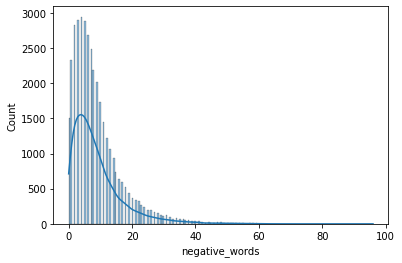

In [13]:
sns.histplot(data=df, x="negative_words", kde=True)

<AxesSubplot:xlabel='positive_words', ylabel='Count'>

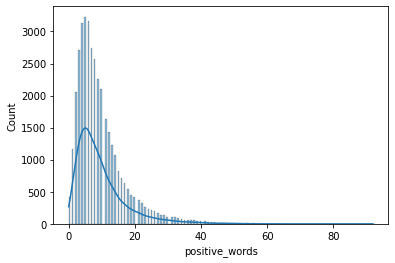

In [14]:
sns.histplot(data=df, x="positive_words", kde=True)

In [15]:
# conti_data = df[['sentiment','positive_words','negative_words','ratio_pos_neg']]
# data = pd.melt(conti_data,id_vars="sentiment",
#                     var_name="features",
#                     value_name='value')

In [16]:
import plotly.express as px
fig = px.scatter(df, x="positive_words", y="negative_words", color="sentiment")
fig.show()

In [17]:
fig = px.scatter_3d(df, x='positive_words', y='negative_words', z='ratio_pos_neg',
              color='sentiment')
fig.show()

### WordCloud 

<function matplotlib.pyplot.show(close=None, block=None)>

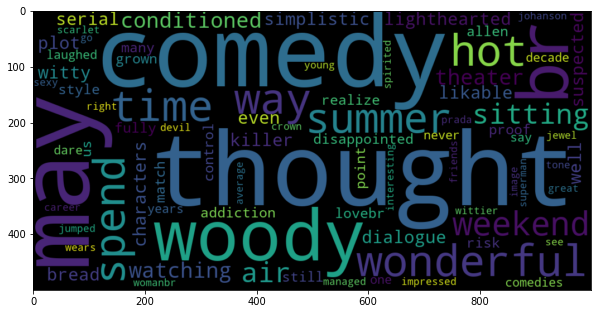

In [18]:
from wordcloud import WordCloud,STOPWORDS
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=df.review[2]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

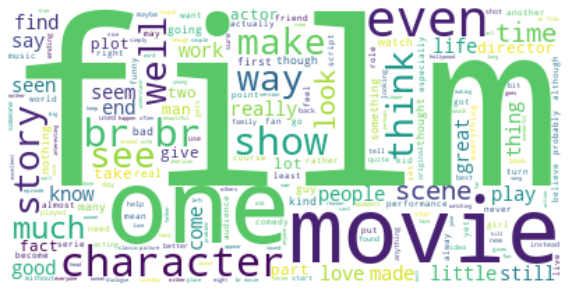

In [19]:
from PIL import Image
def display_cloud(data,color):
    plt.subplots(figsize=(10,10))
#     mask = np.array(Image.open(img_path))
    wc = WordCloud(stopwords=STOPWORDS, background_color="white", contour_color=color,
                   max_words=3000, max_font_size=256,
                   random_state=42)
    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
display_cloud(df['review'],'red')

Total Counts of both sets 1    19923
0    17751
Name: sentiment, dtype: int64


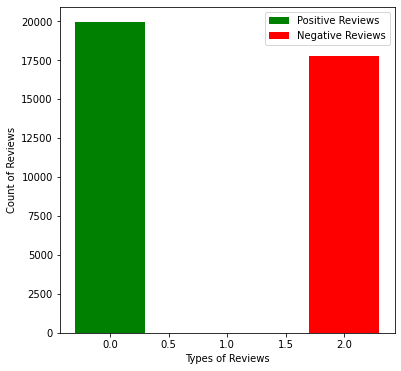

In [20]:
#Count of good and bad reviews
count=df['sentiment'].value_counts()
print('Total Counts of both sets'.format(),count)

#Creating a function to plot the counts using matplotlib
def plot_counts(count_good,count_bad):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_good,width=0.6,label='Positive Reviews',color='Green')
    plt.legend()
    plt.bar(2,count_bad,width=0.6,label='Negative Reviews',color='Red')
    plt.legend()
    plt.ylabel('Count of Reviews')
    plt.xlabel('Types of Reviews')
    plt.show()
    
count_good=df[df['sentiment']==1]
count_bad=df[df['sentiment']==0]
plot_counts(len(count_good),len(count_bad))

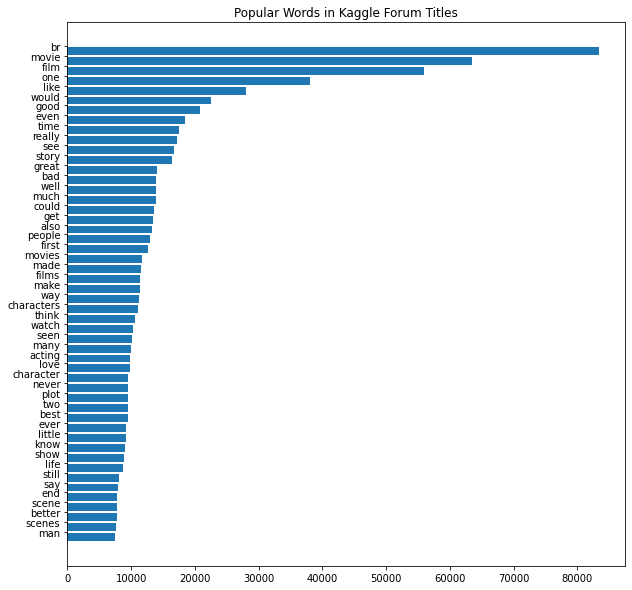

In [21]:
def wordBarGraphFunction(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()
    
plt.figure(figsize=(10,10))
wordBarGraphFunction(df,'review',"Popular Words in Kaggle Forum Titles")

### Splitting Train/Test Data

In [22]:
X = df[['review','positive_words','negative_words','ratio_pos_neg']]
Y = df ['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [23]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(33906, 4) (33906,)
(3768, 4) (3768,)


### Vectorization using CountVectorizer and TfidfVectorizer

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train['review'])
#transformed test reviews

print('Cv_train:',cv_train_reviews.shape)


Cv_train: (33906, 5550395)


In [25]:
cv_test_reviews=cv.transform(X_test['review'])
print('Cv_test:',cv_test_reviews.shape)

Cv_test: (3768, 5550395)


In [26]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train['review'])
print('Tfidf_train:',tv_train_reviews.shape)


Tfidf_train: (33906, 5550395)


In [27]:
tv_test_reviews=tv.transform(X_test['review'])
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_test: (3768, 5550395)


#### Applying TruncatedSVD on CountVectorizer to reduce dimension to 50 so that I can add the custom features to the matrix formed

In [28]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
svd.fit(cv_train_reviews)
Xcv_train_truncated = svd.fit_transform(cv_train_reviews)

In [29]:
Xcv_train_truncated.shape

(33906, 50)

In [30]:
Xcv_test_truncated=svd.transform(cv_test_reviews)
Xcv_test_truncated.shape

(3768, 50)

#### Applying TruncatedSVD on TfidfVectorizer to reduce dimension so that I can add the custom features to the matrix formed

In [31]:
svd_tf = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
svd_tf.fit(tv_train_reviews)
Xtf_train_truncated = svd_tf.fit_transform(tv_train_reviews)
Xtf_train_truncated.shape

(33906, 50)

In [32]:
Xtf_test_truncated=svd.transform(tv_test_reviews)
Xtf_test_truncated.shape

(3768, 50)

#### Converting new features to numpy array so that we can add it to the final CountVectorizer and TfidfVectorizer matrix

In [33]:
train_add_features = X_train[['positive_words','negative_words','ratio_pos_neg']].to_numpy()
test_add_features = X_test[['positive_words','negative_words','ratio_pos_neg']].to_numpy()

In [34]:
print(train_add_features.shape)
print(test_add_features.shape)

(33906, 3)
(3768, 3)


In [35]:
X_train_cv = np.c_[Xcv_train_truncated ,train_add_features]
X_test_cv = np.c_[Xcv_test_truncated ,test_add_features]
X_train_tf = np.c_[Xtf_train_truncated ,train_add_features]
X_test_tf = np.c_[Xtf_test_truncated ,test_add_features]

In [36]:
print(X_train_cv.shape)
print(X_test_cv.shape)
print(X_train_tf.shape)
print(X_test_tf.shape)

(33906, 53)
(3768, 53)
(33906, 53)
(3768, 53)


### Modelling the dataset on CountVectorizer

In [37]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(X_train_cv,y_train)
print(lr_bow)

LogisticRegression(C=1, max_iter=500, random_state=42)


### Accuracy of the model

In [38]:
lr_bow_predict=lr.predict(X_test_cv)
# print(lr_bow_predict)
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.9684182590233545


### Classification report

In [39]:
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.94      1.00      0.97      1799
    Negative       1.00      0.94      0.97      1969

    accuracy                           0.97      3768
   macro avg       0.97      0.97      0.97      3768
weighted avg       0.97      0.97      0.97      3768



### Confusion Matrix

<AxesSubplot:>

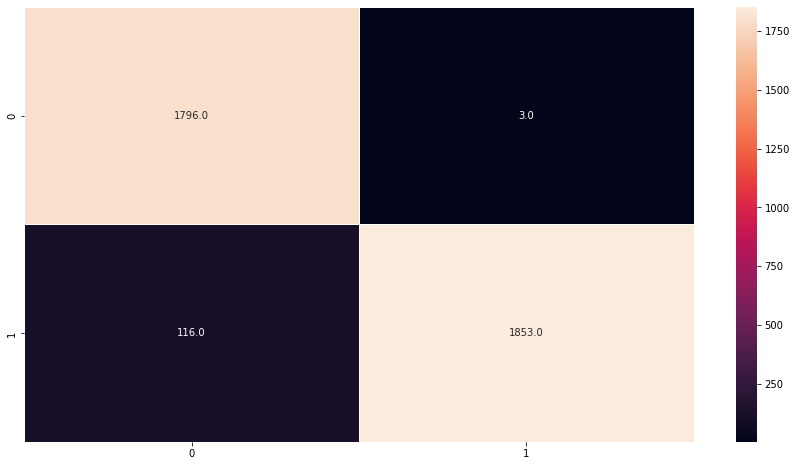

In [40]:
plt.figure(figsize=(15,8))
conf_mx = confusion_matrix(y_test, lr_bow_predict)
conf_mx
sns.heatmap(conf_mx, annot=True, linewidths=.5, fmt= '.1f')

### Modelling the dataset on TfidfVectorizer

In [41]:
lr_tfidf=lr.fit(X_train_tf,y_train)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


In [42]:
lr_tfidf_predict=lr.predict(X_test_tf)
# print(lr_tfidf_predict)

### Accuracy of the model

In [43]:
lr_tfidf_score=accuracy_score(y_test,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.9692144373673036


### Classification report

In [44]:
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.94      1.00      0.97      1799
    Negative       1.00      0.94      0.97      1969

    accuracy                           0.97      3768
   macro avg       0.97      0.97      0.97      3768
weighted avg       0.97      0.97      0.97      3768



### Confusion Matrix

<AxesSubplot:>

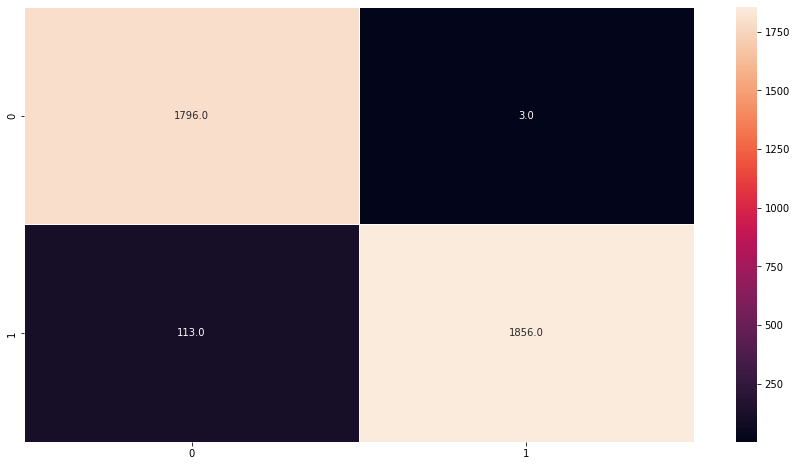

In [45]:
plt.figure(figsize=(15,8))
conf_mx = confusion_matrix(y_test, lr_tfidf_predict)
conf_mx
sns.heatmap(conf_mx, annot=True, linewidths=.5, fmt= '.1f')

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [47]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [48]:
rfc1.fit(X_train_cv, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [49]:
pred=rfc1.predict(X_test_cv)

In [50]:
rfc1_report=classification_report(y_test,pred,target_names=['Positive','Negative'])
print(rfc1_report)

              precision    recall  f1-score   support

    Positive       0.94      1.00      0.97      1799
    Negative       1.00      0.94      0.97      1969

    accuracy                           0.97      3768
   macro avg       0.97      0.97      0.97      3768
weighted avg       0.97      0.97      0.97      3768



In [51]:
rfc_score =accuracy_score(y_test,pred)
print("rfc_score :",rfc_score)

rfc_score : 0.9686836518046709


In [52]:
tf = rfc1.fit(X_train_tf, y_train)
pred_tf = tf.predict(X_test_cv)

In [53]:
rfc1tf_report=classification_report(y_test,pred_tf,target_names=['Positive','Negative'])
print(rfc1_report)

              precision    recall  f1-score   support

    Positive       0.94      1.00      0.97      1799
    Negative       1.00      0.94      0.97      1969

    accuracy                           0.97      3768
   macro avg       0.97      0.97      0.97      3768
weighted avg       0.97      0.97      0.97      3768



In [54]:
rfc_score =accuracy_score(y_test,pred_tf)
print("rfc_score :",rfc_score)

rfc_score : 0.9689490445859873


<AxesSubplot:>

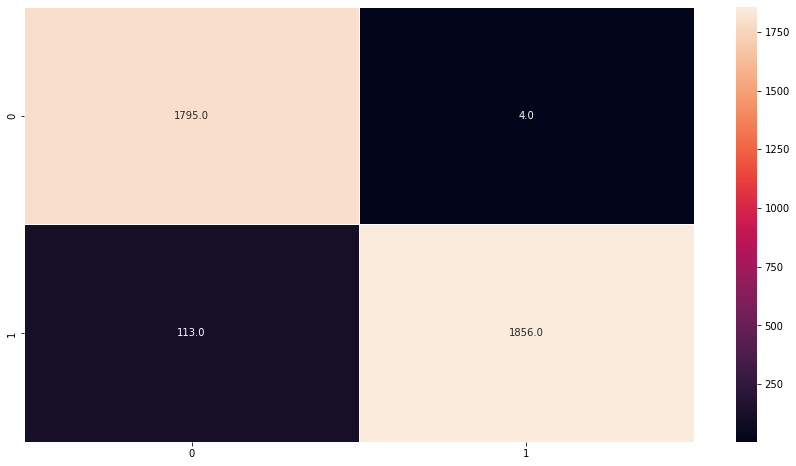

In [55]:
plt.figure(figsize=(15,8))
conf_mx = confusion_matrix(y_test, pred_tf)
conf_mx
sns.heatmap(conf_mx, annot=True, linewidths=.5, fmt= '.1f')